# BILSTM - MAX_LEN 39 - EMBEDDINGS OWN - TEST_ACC 97.25

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Input,Embedding,Bidirectional,LSTM,TimeDistributed,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard,ReduceLROnPlateau

## PreProcess Data

In [2]:
def process_csv(csv):
    df = pd.read_csv(csv)
    df=df.drop(columns=['Case','lemma', 'Gender','Number','State','Gloss','Proclitic 1','Proclitic 2','Proclitic 0','Aspect','Mood','Person','Voice','Enclitic 0'])
    df=df.drop_duplicates()
    df["POS"] = df["POS"].apply(lambda x: x.replace("Proper Noun", "ProperNoun"))
    df1 = pd.DataFrame(columns = ['x','y'])
    for i in df['sentence_id'].unique():
        df1 = df1.append({'x':df[df['sentence_id'] == i]['word'].tolist() , 'y':df[df['sentence_id'] == i]['POS'].tolist()}, ignore_index=True)
    return df1

In [3]:
csvs = os.listdir('Dataset/')
final_df = pd.DataFrame()
for csv in csvs:
    df = process_csv('Dataset/'+csv)
    final_df = pd.concat([final_df,df])
final_df = final_df.sample(frac = 1)
final_df.reset_index(drop=True, inplace=True)
final_df.head()

C:\Users\KUSHBAB\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,x,y
0,"[أحرز, النجم, البرتغالى, برونو, فيرنانديز, ,, ...","[Verb, Noun, Adjective, ProperNoun, ProperNoun..."
1,"[خلال, اجتماع, مجلس, الوزراء, اليوم, الخميس, ,...","[Noun, Noun, Noun, Noun, Noun, Noun, Punctuati..."
2,"[كشفت, تقارير, صحفية, إيطالية, ,, أن, قرار, رئ...","[Verb, Noun, Adjective, Adjective, Punctuation..."
3,"[إيه, الفرق, ?, ., أبرز, الاختلافات, بين, جهاز...","[Abbreviation, Noun, Punctuation, Punctuation,..."
4,"[أخبار, ×, 24, ساعة, ., الصحة, :, توفير, لقاح,...","[Noun, ProperNoun, Digit, Noun, Punctuation, N..."


In [4]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = max([len(final_df['x'][i]) for i in range(len(final_df))])

In [5]:
x_tokenizer = Tokenizer(oov_token = "<OOV>")                    
x_tokenizer.fit_on_texts(final_df['x'].tolist())  
VOCABULARY_SIZE = len(x_tokenizer.word_index) + 1                  
x = x_tokenizer.texts_to_sequences(final_df['x'].tolist())  

In [6]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(final_df['y'].tolist())
y = y_tokenizer.texts_to_sequences(final_df['y'].tolist())

In [7]:
x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = to_categorical(y)

In [8]:
x_train = np.array(x[:int(len(x)*0.7)])
x_val = np.array(x[int(len(x)*0.7):int(len(x)*0.9)])
x_test = np.array(x[int(len(x)*0.9):])
assert len(x_train)+len(x_val)+len(x_test) == len(x)

In [9]:
y_train = np.array(y[:int(len(y)*0.7)])
y_val = np.array(y[int(len(y)*0.7):int(len(y)*0.9)])
y_test = np.array(y[int(len(y)*0.9):])
assert len(y_train)+len(y_val)+len(y_test) == len(y)

In [10]:
print("Training data shape (x y) ", x_train.shape,y_train.shape)
print("Validation data shape (x y) ", x_val.shape,y_val.shape)
print("Test data shape (x y) ", x_test.shape,y_test.shape)

Training data shape (x y)  (10000, 39) (10000, 39, 33)
Validation data shape (x y)  (2858, 39) (2858, 39, 33)
Test data shape (x y)  (1429, 39) (1429, 39, 33)


## Embedding Matrix

In [ ]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

In [ ]:
import gensim
embedding_model = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')
embeddings = {}
for word,vector in zip(embedding_model.wv.vocab,embedding_model.wv.vectors):
    coefs = np.array(vector, dtype='float32')
    embeddings[word] = coefs
embeddings_weights = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

## Create Model

In [11]:
tagger = Sequential()
tagger.add(Input((MAX_SEQUENCE_LENGTH)))
tagger.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim, input_length  = MAX_SEQUENCE_LENGTH,#weights = [embeddings_matrix],
                             trainable     = True))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger
tagger.add(TimeDistributed(Dense(y.shape[2], activation='softmax')))
tagger.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
tagger.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           9859500   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 39, 512)           1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 39, 512)           1574912   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 39, 512)           1574912   
_________________________________________________________________
time_distributed (TimeDistri (None, 39, 33)            16929     
Total params: 15,741,901
Trainable params: 15,741,901
Non-trainable params: 0
____________________________________________

## Train Model

In [12]:
checkpoint = ModelCheckpoint('model1_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min' , min_lr=0.0001)

In [13]:
result = tagger.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 40, batch_size= 128, shuffle = True,callbacks=[checkpoint,reducelr])

Epoch 1/40
79/79 [==============================] - 169s 2s/step - loss: 1.4424 - accuracy: 0.6352 - val_loss: 0.8376 - val_accuracy: 0.7529

Epoch 00001: val_accuracy improved from -inf to 0.75291, saving model to model_checkpoint.h5
Epoch 2/40
79/79 [==============================] - 170s 2s/step - loss: 0.8178 - accuracy: 0.7634 - val_loss: 0.7717 - val_accuracy: 0.7685

Epoch 00002: val_accuracy improved from 0.75291 to 0.76853, saving model to model_checkpoint.h5
Epoch 3/40
79/79 [==============================] - 192s 2s/step - loss: 0.7246 - accuracy: 0.7787 - val_loss: 0.3764 - val_accuracy: 0.8919

Epoch 00003: val_accuracy improved from 0.76853 to 0.89193, saving model to model_checkpoint.h5
Epoch 4/40
79/79 [==============================] - 240s 3s/step - loss: 0.2768 - accuracy: 0.9231 - val_loss: 0.2191 - val_accuracy: 0.9431

Epoch 00004: val_accuracy improved from 0.89193 to 0.94307, saving model to model_checkpoint.h5
Epoch 5/40
79/79 [==============================] -

79/79 [==============================] - 240s 3s/step - loss: 5.1363e-04 - accuracy: 1.0000 - val_loss: 0.2345 - val_accuracy: 0.9710

Epoch 00037: val_accuracy did not improve from 0.97131
Epoch 38/40
79/79 [==============================] - 251s 3s/step - loss: 4.9235e-04 - accuracy: 1.0000 - val_loss: 0.2393 - val_accuracy: 0.9712

Epoch 00038: val_accuracy did not improve from 0.97131
Epoch 39/40
79/79 [==============================] - 237s 3s/step - loss: 5.5491e-04 - accuracy: 1.0000 - val_loss: 0.2375 - val_accuracy: 0.9709

Epoch 00039: val_accuracy did not improve from 0.97131
Epoch 40/40
79/79 [==============================] - 233s 3s/step - loss: 8.1327e-04 - accuracy: 0.9999 - val_loss: 0.2431 - val_accuracy: 0.9712

Epoch 00040: val_accuracy did not improve from 0.97131


## Evaluate Model

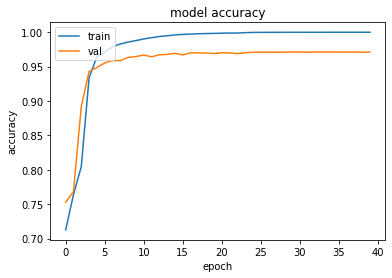

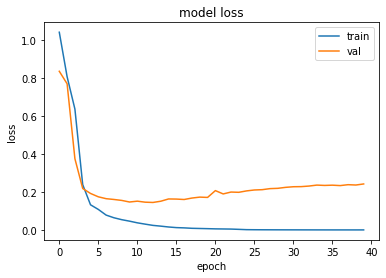

In [20]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [21]:
tagger.load_weights('model1_checkpoint.h5')

In [22]:
loss, accuracy = tagger.evaluate(x_test, y_test)
print('Loss:',loss)
print('Accuracy:',accuracy)

45/45 [==============================] - 14s 306ms/step - loss: 0.2237 - accuracy: 0.9725
Loss: 0.22373922169208527
Accuracy: 0.9725287556648254


## Predict 

In [53]:
def pos_tagger(sent):
    words = sent.split()
    words = [x_tokenizer.texts_to_sequences(words)]
    words = pad_sequences(words, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    words = np.squeeze(words,axis=-1)
    tags = np.squeeze(tagger.predict(words).argmax(-1))
    tags = [y_tokenizer.index_word[tag] for tag in tags if tag != 0]
    return tags

In [54]:
sentence = "جون يحب البيت الأزرق في نهاية الشارع"
output = pos_tagger(sentence)
pred_tags = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
for w,t in pred_tags:
    print(w,t)

جون propernoun
يحب verb
البيت noun
الأزرق noun
في preposition
نهاية noun
الشارع noun


## Evaluate Prediction

In [76]:
from evaluate_pred import *
evaluate(sentence, pred_tags)

100.0